#The Simpson Character Classification


*   Nama : Sya Raihan Heggi
*   Dicoding ID : raihan_heggi
*   Unique Data : 20933 ; Train Acc : 92% ; Validation Acc : 90%
*   Model Created to Classify 43 Simpsons Character







### Dataset From Kaggle

In [ ]:
# install kaggle package
!pip install -q kaggle

In [ ]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"syaraihanheggi","key":"99e579549682f4e3749c5bf136fef0ee"}'}

In [ ]:
# make directory and change permission
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

# test kaggle dataset list
!kaggle datasets list

kaggle.json
ref                                                             title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                 DAIGT V2 Train Dataset                            29MB  2023-11-16 01:38:36           2342        216  1.0              
manjitbaishya001/la-crime-data-2010-to-2023                     Los Angeles Crime Data - 2010 to 2023            147MB  2023-12-19 13:20:31            762         22  1.0              
thedevastator/netflix-imdb-scores                               Netflix IMDB Scores                              699KB  2023-12-03 14:10:34           4649         81  1.0              
muhammadbinimran/housing-price-prediction-data                 

In [ ]:
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

100% 1.07G/1.08G [00:36<00:00, 34.7MB/s]
100% 1.08G/1.08G [00:36<00:00, 31.6MB/s]


In [ ]:
# unzip
!mkdir the-simpsons-characters-dataset
!unzip the-simpsons-characters-dataset.zip -d dataset
!ls dataset


Streaming output truncated to the last 5000 lines.
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1272.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1273.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1274.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1275.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1276.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1277.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1278.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1279.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1280.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1281.jpg  
  inflating: dataset/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1282.jpg  
  inflating: dataset/simpsons_dataset/simpsons_

### Load Dataset

In [ ]:
!pip install split-folders

In [ ]:
import numpy as np
import pandas as pd

from keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
import tensorflow as tf
import splitfolders

import matplotlib.pyplot as plt
import os
from PIL import Image
import glob
import pathlib

In [ ]:
# Check Count Data
input_dir = "/content/dataset/simpsons_dataset"
output_dir = "./splitted_data"

# Split Train and Val 20%
splitfolders.ratio(input_dir, output=output_dir,seed=1337, ratio=(.8, 0.2))

# Set Dir Val and Train
train_dir = output_dir+'/train'
val_dir = output_dir+'/val'

Copying files: 20933 files [00:05, 3761.86 files/s]


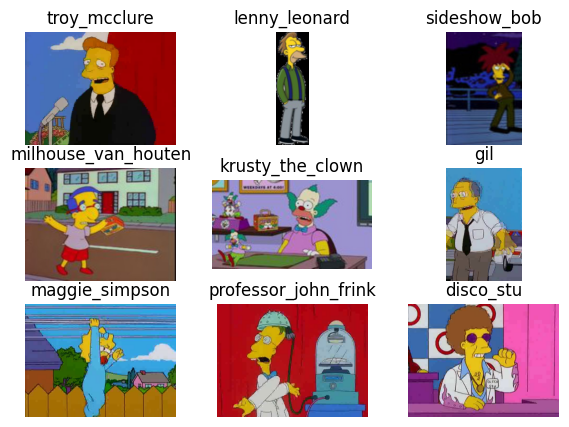

In [ ]:
# Preview
plt.figure(figsize=(7, 5))
i = 1
for x in os.listdir(train_dir):
   if(i == 10):
       break
   else :
      if(x != 'simpsons_dataset'):
        ax = plt.subplot(3, 3, i)
        plt.imshow(Image.open(train_dir + '/' + x + '/' + 'pic_0001.jpg'))
        plt.title(x)
        plt.axis("off")
        i += 1


### Image Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        color_mode='rgb')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        class_mode='categorical',
        color_mode="rgb")

Found 16727 images belonging to 43 classes.
Found 4206 images belonging to 43 classes.


### Model Creation

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(43, activation='softmax')
])

model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 73, 73, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 64)        36928     
                                                        

In [ ]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') >= 0.9):
      self.model.stop_training = True
      print("\nThe accuracy of validation set has reached > 90%!")

callbacks = myCallback()

In [ ]:
BATCH_SIZE = 150
EPOCHS = 300
NUM_TRAIN_DATA = train_generator.n
NUM_VALID_DATA = validation_generator.n

In [ ]:
history = model.fit(train_generator,
          steps_per_epoch= NUM_TRAIN_DATA // BATCH_SIZE,
          epochs= EPOCHS,
          validation_data= validation_generator,
          validation_steps= NUM_VALID_DATA // BATCH_SIZE,
          callbacks=[callbacks],
          verbose= 1)

Epoch 1/300
111/111 [==============================] - 60s 363ms/step - loss: 3.2402 - accuracy: 0.0974 - val_loss: 3.1451 - val_accuracy: 0.1071
Epoch 2/300
111/111 [==============================] - 39s 354ms/step - loss: 3.1612 - accuracy: 0.0952 - val_loss: 3.0699 - val_accuracy: 0.0982
Epoch 3/300
111/111 [==============================] - 37s 334ms/step - loss: 2.9717 - accuracy: 0.1592 - val_loss: 2.8114 - val_accuracy: 0.2143
Epoch 4/300
111/111 [==============================] - 39s 355ms/step - loss: 2.8036 - accuracy: 0.2030 - val_loss: 2.6746 - val_accuracy: 0.2567
Epoch 5/300
111/111 [==============================] - 35s 314ms/step - loss: 2.7842 - accuracy: 0.2111 - val_loss: 2.7018 - val_accuracy: 0.2165
Epoch 6/300
111/111 [==============================] - 37s 337ms/step - loss: 2.6922 - accuracy: 0.2441 - val_loss: 2.5038 - val_accuracy: 0.2779
Epoch 7/300
111/111 [==============================] - 37s 337ms/step - loss: 2.6181 - accuracy: 0.2655 - val_loss: 2.5353 -

In [ ]:
def eval_plot(history):

  plt.figure(figsize=(25, 5))

  # Accuracy plot
  plt.subplot(1, 4, 1)
  epochs = [x for x in range(158)]
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  acc_plot, = plt.plot(epochs, acc, label='Training Accuracy')
  val_acc_plot = plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  # Loss plot
  plt.subplot(1, 4, 2)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])



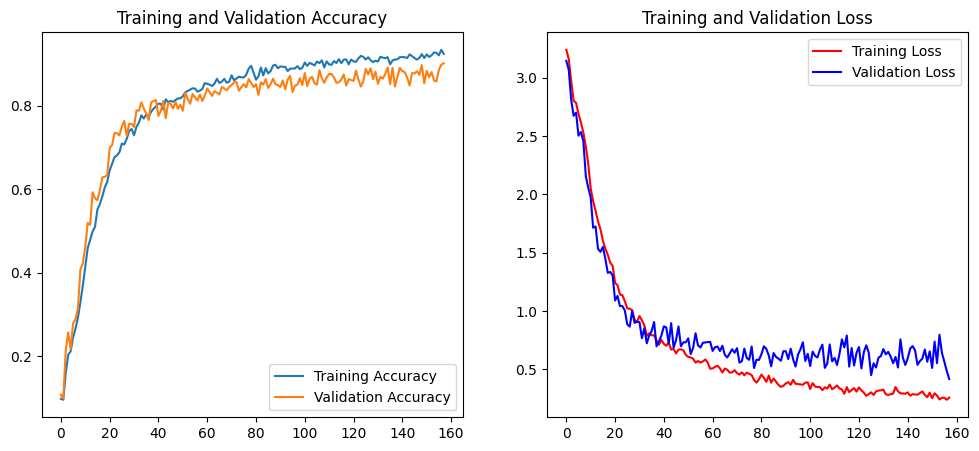

In [ ]:
eval_plot(history)

In [ ]:
# Save Model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

#Download converted model
files.download('model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>